In [1]:
#pip install --upgrade "protobuf<=3.20.1"

In [2]:
# ! git clone https://github.com/hieuminh65/codespaces-jupyter.git

In [3]:
#necessary imports
import librosa
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import glob,os
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
random.seed(1)

In [5]:
# Extracting features from each .wav file
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [6]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)


In [7]:
#Emotions in the dataset
emotions={
  '01':'neutral',
  #'02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  #'07':'disgust',
  #'08':'surprised'
}

#Emotions to observe
#observed_emotions=['calm', 'happy', 'fearful', 'disgust', 'sad']


In [8]:
emotions2={
    'NEU': 'neutral',
    'HAP': 'happy',
    'SAD': 'sad',
    'ANG': 'angry',
    'FEA': 'fearful',
}

In [9]:
def get_features(path, isTraining):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    #data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Augmenting only training data and skipping augmentation for test data
    if isTraining:

        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data, sample_rate)
        result = np.vstack((result, res2)) # stacking vertically

        # data with stretching
        stretched_data = stretch(data)
        res3 = extract_features(stretched_data, sample_rate)
        result = np.vstack((result, res3)) # stacking vertically

        # data with pitch offset
        data_pitch = pitch(data, sample_rate)
        res4 = extract_features(data_pitch, sample_rate)
        result = np.vstack((result, res4)) # stacking vertically

    return result

# New Data
## Crema-D dataset

In [10]:
Creama = "/content/codespaces-jupyter/data2/"
creama_directory_list = os.listdir(Creama)

file_emotion = []
file_path = []
for file in glob.glob(f"{Creama}*"):
    part = file.split('.')[0]
    part = part.split('_')
    if part[2] not in emotions2.keys():
        continue
    file_emotion.append(part[2])
    file_path.append(file)

# dataframe for emotion of files
emotion2_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files
path2_df = pd.DataFrame(file_path, columns=['Path'])
Creama_df = pd.concat([emotion2_df, path2_df], axis=1)

# Mapping integers to corresponding emotions
Creama_df = Creama_df.replace({'Emotions': emotions2})
print(Creama_df["Emotions"].unique())


['happy' 'fearful' 'angry' 'sad' 'neutral']


In [11]:
# Creating Dataframes
Ravdess = "/content/codespaces-jupyter/data/"
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for folder in glob.glob(f"{Ravdess}Actor_*"):
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(folder)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        if part[2] not in emotions.keys():
            continue
        file_emotion.append(int(part[2]))
        file_path.append(folder + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


# dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Mapping integers to corresponding emotions
Ravdess_df.Emotions.replace({1:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fearful'}, inplace=True)
# ? """Ravdess_df.head()"""

data = pd.concat([Creama_df, Ravdess_df], axis=0)

X = data["Path"]
Y = data["Emotions"]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [ ]:
Y_train.value_counts(), Y_test.value_counts()

In [13]:
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(5276,)
(5276,)
(1759,)
(1759,)


In [14]:
X, Y = [], []
for path, emotion in zip(X_train, Y_train):
    feature = get_features(path, True)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have applied 4 augmentation techniques on each audio file
        Y.append(emotion)
x_train = X
y_train = Y

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [15]:
# Saving features in a csv file to avoid redundant feature extraction
Features = pd.DataFrame(x_train)
Features['labels'] = y_train
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.109337,0.538946,0.559595,0.561073,0.656845,0.753396,0.718244,0.821912,0.757459,0.779076,...,0.010531,0.006776,0.011303,0.016263,0.007811,0.013106,0.005727,0.001438,0.000038,happy
1,0.211031,0.526032,0.559015,0.564690,0.605275,0.759825,0.735481,0.794664,0.827997,0.767552,...,0.013349,0.010276,0.013998,0.018341,0.010523,0.017073,0.009190,0.004196,0.003037,happy
2,0.125305,0.468952,0.529941,0.534854,0.570197,0.740940,0.719575,0.775312,0.788141,0.757632,...,0.005620,0.002977,0.006016,0.008066,0.003712,0.006593,0.002881,0.000786,0.000020,happy
3,0.123047,0.510770,0.550830,0.592938,0.580308,0.691380,0.720800,0.802385,0.845298,0.772511,...,0.012361,0.009428,0.007688,0.003160,0.006633,0.009709,0.003646,0.000754,0.000045,happy
4,0.116362,0.673909,0.713651,0.602404,0.590360,0.734210,0.640220,0.521658,0.541095,0.575332,...,0.022717,0.026103,0.045411,0.040773,0.028045,0.008673,0.001482,0.000316,0.000006,happy


In [16]:
x_train = Features.iloc[: ,:-1].values
y_train = Features['labels'].values
print(y_train)

['happy' 'happy' 'happy' ... 'neutral' 'neutral' 'neutral']


In [17]:
encoder = sklearn.preprocessing.OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
print(y_train)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [18]:
X, Y = [], []
for path, emotion in zip(X_test, Y_test):
    feature = get_features(path, False)
    X.append(feature)
    Y.append(emotion)

print(np.shape(X))
print(np.shape(Y))
x_test = np.array(X)
y_test = np.array(Y)


(1759, 162)
(1759,)


In [19]:
Y_test.head(5)

4003        sad
474        fear
3927    fearful
4694    fearful
1237    fearful
Name: Emotions, dtype: object

In [20]:
X_test.head(5)

4003    /content/codespaces-jupyter/data2/1041_WSI_SAD...
474     /content/codespaces-jupyter/data/Actor_24/03-0...
3927    /content/codespaces-jupyter/data2/1036_IEO_FEA...
4694    /content/codespaces-jupyter/data2/1023_IWL_FEA...
1237    /content/codespaces-jupyter/data2/1087_TSI_FEA...
Name: Path, dtype: object

In [21]:
encoder = sklearn.preprocessing.OneHotEncoder()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [22]:
# Normalization
scaler = sklearn.preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21104, 162), (21104, 6), (1759, 162), (1759, 6))

In [23]:
model1=MLPClassifier(alpha=0.01, batch_size=64, epsilon=1e-08, hidden_layer_sizes=(500,), learning_rate='adaptive', max_iter=500)
model1.fit(x_train,y_train)
score = model1.score(x_test, y_test)
print("Accuracy:", score)

Accuracy: 0.3916998294485503


In [24]:
# Reshaping train and test data for new model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21104, 162, 1), (21104, 6), (1759, 162, 1), (1759, 6))

# Model

In [62]:
from keras.optimizers import Adam
model = Sequential()
model.add(Conv1D(64, 3, padding='same',activation='relu', input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(32, 3, padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(y_train.shape[1],activation='softmax')) # Target class number
model.compile(optimizer = Adam(learning_rate=2e-4) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          (None, 162, 64)           576       
                                                                 
 dropout_25 (Dropout)        (None, 162, 64)           0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 20, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 20, 16)            8208      
                                                                 
 flatten_8 (Flatten)         (None, 320)               0         
                                                                 
 dense_19 (Dense)            (None, 6)                 1926      
                                                     

In [63]:
model_path = 'model_checkpoint/'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.00001)
history=model.fit(x_train, y_train, batch_size=8, epochs=90, validation_data=(x_test, y_test), callbacks=[rlrp, checkpoint, stop])

Epoch 1/90
2634/2638 [============================>.] - ETA: 0s - loss: 1.3019 - accuracy: 0.4444
Epoch 1: val_accuracy improved from -inf to 0.47413, saving model to model_checkpoint/


2638/2638 [==============================] - 11s 4ms/step - loss: 1.3019 - accuracy: 0.4443 - val_loss: 1.2432 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 2/90
2637/2638 [============================>.] - ETA: 0s - loss: 1.1740 - accuracy: 0.5088
Epoch 2: val_accuracy improved from 0.47413 to 0.48550, saving model to model_checkpoint/


2638/2638 [==============================] - 9s 3ms/step - loss: 1.1742 - accuracy: 0.5088 - val_loss: 1.2568 - val_accuracy: 0.4855 - lr: 0.0010
Epoch 3/90
2632/2638 [============================>.] - ETA: 0s - loss: 1.1348 - accuracy: 0.5246
Epoch 3: val_accuracy improved from 0.48550 to 0.49972, saving model to model_checkpoint/


2638/2638 [==============================] - 10s 4ms/step - loss: 1.1349 - accuracy: 0.5245 - val_loss: 1.2100 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 4/90
2627/2638 [============================>.] - ETA: 0s - loss: 1.1075 - accuracy: 0.5396
Epoch 4: val_accuracy did not improve from 0.49972
2638/2638 [==============================] - 9s 3ms/step - loss: 1.1074 - accuracy: 0.5395 - val_loss: 1.2282 - val_accuracy: 0.4895 - lr: 0.0010
Epoch 5/90
2637/2638 [============================>.] - ETA: 0s - loss: 1.0876 - accuracy: 0.5455
Epoch 5: val_accuracy improved from 0.49972 to 0.51052, saving model to model_checkpoint/


2638/2638 [==============================] - 10s 4ms/step - loss: 1.0875 - accuracy: 0.5455 - val_loss: 1.1844 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 6/90
2629/2638 [============================>.] - ETA: 0s - loss: 1.0741 - accuracy: 0.5527
Epoch 6: val_accuracy improved from 0.51052 to 0.51507, saving model to model_checkpoint/


2638/2638 [==============================] - 9s 3ms/step - loss: 1.0739 - accuracy: 0.5530 - val_loss: 1.1718 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 7/90
2620/2638 [============================>.] - ETA: 0s - loss: 1.0598 - accuracy: 0.5558
Epoch 7: val_accuracy did not improve from 0.51507
2638/2638 [==============================] - 10s 4ms/step - loss: 1.0600 - accuracy: 0.5559 - val_loss: 1.1726 - val_accuracy: 0.4991 - lr: 0.0010
Epoch 8/90
2637/2638 [============================>.] - ETA: 0s - loss: 1.0534 - accuracy: 0.5612
Epoch 8: val_accuracy improved from 0.51507 to 0.52132, saving model to model_checkpoint/


2638/2638 [==============================] - 11s 4ms/step - loss: 1.0535 - accuracy: 0.5611 - val_loss: 1.1563 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 9/90
2634/2638 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.5650
Epoch 9: val_accuracy did not improve from 0.52132
2638/2638 [==============================] - 9s 3ms/step - loss: 1.0384 - accuracy: 0.5651 - val_loss: 1.1633 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 10/90
2637/2638 [============================>.] - ETA: 0s - loss: 1.0339 - accuracy: 0.5688
Epoch 10: val_accuracy improved from 0.52132 to 0.54008, saving model to model_checkpoint/


2638/2638 [==============================] - 9s 3ms/step - loss: 1.0338 - accuracy: 0.5688 - val_loss: 1.1539 - val_accuracy: 0.5401 - lr: 0.0010
Epoch 11/90
2628/2638 [============================>.] - ETA: 0s - loss: 1.0256 - accuracy: 0.5705
Epoch 11: val_accuracy did not improve from 0.54008
2638/2638 [==============================] - 9s 3ms/step - loss: 1.0254 - accuracy: 0.5709 - val_loss: 1.1923 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 12/90
2621/2638 [============================>.] - ETA: 0s - loss: 1.0199 - accuracy: 0.5745
Epoch 12: val_accuracy did not improve from 0.54008
2638/2638 [==============================] - 9s 3ms/step - loss: 1.0204 - accuracy: 0.5744 - val_loss: 1.2039 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 13/90
2635/2638 [============================>.] - ETA: 0s - loss: 1.0114 - accuracy: 0.5838
Epoch 13: val_accuracy did not improve from 0.54008
2638/2638 [==============================] - 8s 3ms/step - loss: 1.0115 - accuracy: 0.5838 - val_loss: 1.1545

In [64]:
# model.load_weights(model_path)

In [65]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

55/55 [==============================] - 0s 3ms/step - loss: 1.1746 - accuracy: 0.5276
Accuracy of our model on test data :  52.757251262664795 %


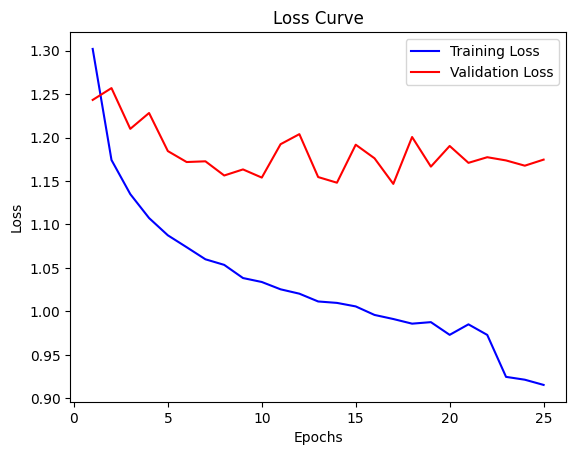

In [66]:
# Access the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)


55/55 [==============================] - 0s 2ms/step


,Predicted Labels,Actual Labels
0,sad,sad
1,fear,fear
2,fearful,fearful
3,angry,fearful
4,sad,fearful
5,fearful,sad
6,angry,angry
7,fearful,sad
8,angry,neutral
9,angry,happy


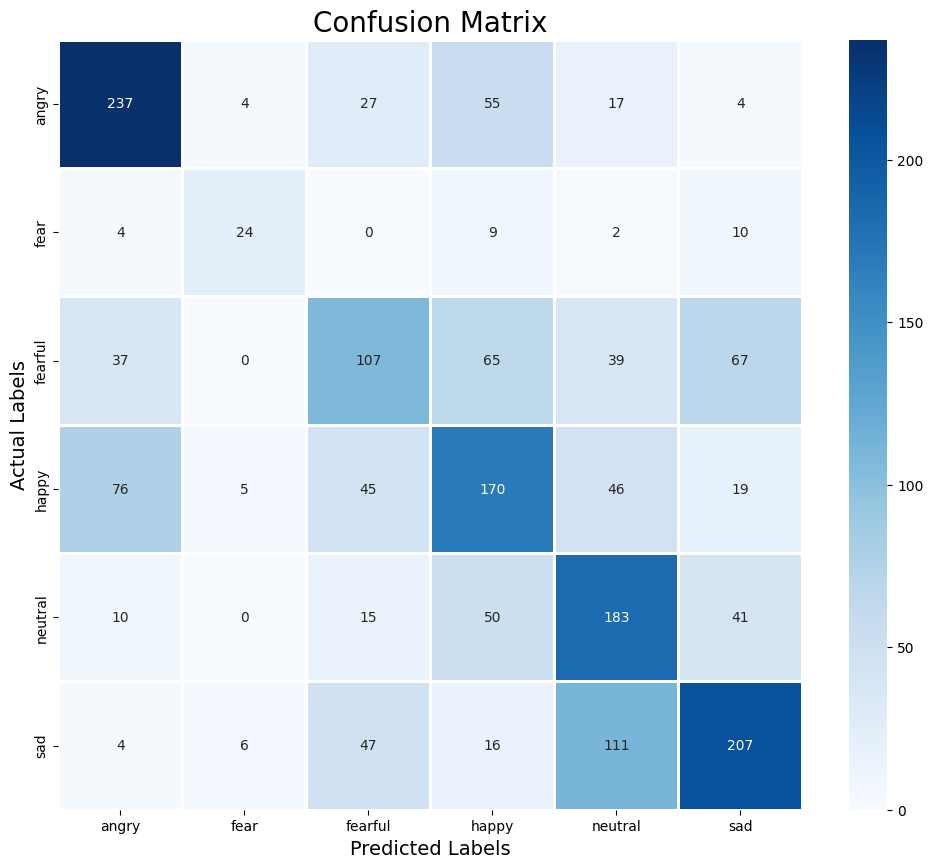

In [68]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [69]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.64      0.69      0.67       344
        fear       0.62      0.49      0.55        49
     fearful       0.44      0.34      0.38       315
       happy       0.47      0.47      0.47       361
     neutral       0.46      0.61      0.53       299
         sad       0.59      0.53      0.56       391

    accuracy                           0.53      1759
   macro avg       0.54      0.52      0.52      1759
weighted avg       0.53      0.53      0.52      1759



In [70]:
pip install tf2onnx

In [71]:
import tf2onnx
import tensorflow as tf

onnx_model, _ = tf2onnx.convert.from_keras(model)
tf.io.write_graph(onnx_model, '.', 'model.onnx', as_text=False)

'./model.onnx'

In [72]:
# Saved the current model to replicate results
#dump(model, open('model.pkl', 'wb'))

In [73]:
from pickle import dump
dump(scaler, open('scaler.pkl', 'wb'))

In [74]:
dump(encoder, open('encoder.pkl', 'wb'))

In [75]:
input_name = onnx_model.graph.input[0].name
output_name = onnx_model.graph.output[0].name

print("Input node name:", input_name)
print("Output node name:", output_name)

Input node name: conv1d_33_input
Output node name: dense_19
